In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd 

import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import Angle, EarthLocation, AltAz, SkyCoord
from astropy.time import Time
from astropy.visualization import hist
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter

import corner
import pymc3 as pm
import arviz
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [6]:
MMT_LOCATION = EarthLocation.from_geodetic("-110:53:04.4", "31:41:19.6", 2600 * u.m)
obstime = Time("2021-08-21T06:00:00", format='isot')

# don't strictly need time or location for our purposes, but astropy wants them for defining the alt/az frame
aa_frame = AltAz(obstime=obstime, location=MMT_LOCATION)

def tpoint(
        coo, 
        ia=0., 
        ie=0., 
        an=0., 
        aw=0., 
        ca=0., 
        npae=0., 
        tf=0., 
        tx=0.
    ):
    """
    Apply 8-term alt-az tpoint model to set of raw alt-az coordinates and return corrected coordinates
    """
    da = -1 * ia
    da -= an * np.sin(coo.az) * np.tan(coo.alt)
    da -= aw * np.cos(coo.az) * np.tan(coo.alt)
    da -= ca / np.cos(coo.alt)
    da -= npae * np.tan(coo.alt)

    de = ie
    de -= an * np.cos(coo.az)
    de += aw * np.sin(coo.az)
    de -= tf * np.cos(coo.alt)
    de -= tx / np.tan(coo.alt)

    new_az = coo.az + da * u.arcsec
    new_alt = coo.alt + de * u.arcsec

    new_coo = SkyCoord(new_az, new_alt, frame=aa_frame)
    return new_coo

def skyrms(coo_ref, coo_meas):
    """
    Calculate sky RMS of the offsets between reference and measured coordinates in the same way as tpoint.
    Return the result in arcseconds.
    """
    sep = coo_ref.separation(coo_meas)
    rms = np.sqrt((sep ** 2).mean()).to(u.arcsec)
    return rms

def psd(coo_ref, coo_meas, nterms=8):
    """
    Calculate the population standard deviation, PSD, the way tpoint does. Returh the result in arcseconds. 
    """
    rms = skyrms(coo_ref, coo_meas)
    sd = np.sqrt(rms**2 * len(coo_meas) / (len(coo_meas) - nterms))
    return sd

def pointing_histogram(coo_ref, coo_meas):
    seps = coo_ref.separation(coo_meas)
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        fig, ax = plt.subplots(figsize=[9, 6])
        bins = np.arange(0, 20)/4  # 0.25" bins
        ax.hist(seps.to(u.arcsec).value, bins=bins, alpha=0.6)
        ax.set_ylabel("N")
        ax.set_xlabel("Pointing Error (arcsec)")
        med = np.median(seps.to(u.arcsec))
        rms = skyrms(coo_obs, t_coo)
        skypsd = psd(coo_obs, t_coo)
        ax.vlines(x=med.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls='-', label=f"Median: {med.value:.2f}\"")
        ax.vlines(x=rms.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls='--', label=f"RMS: {rms.value:.2f}\"")
        ax.vlines(x=skypsd.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls=':', label=f"PSD: {skypsd.value:.2f}\"")
        ax.legend()
        ax.set_xlim(0.0, 5.0)
    return fig

def pointing_residuals(coo_ref, coo_meas):
    az_res, el_res = coo_meas.spherical_offsets_to(coo_ref)
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        fig, ax = plt.subplots(figsize=[6, 6])
        ax.set_aspect('equal')
        ax.scatter(az_res.to(u.arcsec), el_res.to(u.arcsec))
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
        ax.set_xlabel("$\Delta$A (arcsec)")
        ax.set_ylabel("$\Delta$E (arcsec)")
        ax.set_title("Azimuth-Elevation Residuals")
        c1 = matplotlib.patches.Circle((0, 0), 1, ec='black', lw=4, fill=False, alpha=0.4, label="1\"")
        ax.add_patch(c1)
        ax.legend()
    return fig

def pointing_sky(coo_ref, coo_meas):
    az_res, el_res = coo_meas.spherical_offsets_to(coo_ref)
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        x = coo_ref.az
        y = 90 * u.degree - coo_ref.alt  # use zenith angle here as a trick
        uu = (az_res).to(u.arcsec).value
        vv = (-1 * el_res).to(u.arcsec).value
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=[8, 8])
        qq = ax.quiver(
            x.to(u.radian).value, 
            y.value, 
            uu, 
            vv, 
            np.sqrt(uu**2 + vv**2),
            scale_units='y', 
            angles='xy', 
            pivot='tip', 
            color='red'
        )
        #qk = ax.quiverkey(qq, 0.95, 0.95, 1, "1\"", labelpos='W', coordinates='axes', angle=0.0)
        ax.set_rmax(90)
        ticks = [0, 15, 30, 45, 60, 75, 90]
        ax.set_rticks(ticks)
        ax.set_rlim(0, 90)
        ax.set_yticklabels([
            "$90^{\circ}$",
            "$75^{\circ}$",
            "$60^{\circ}$",
            "$45^{\circ}$",
            "$30^{\circ}$",
            "$15^{\circ}$",
            "El = $0^{\circ}$",
        ])
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.scatter(x.to(u.radian).value, y.value)
    cbar = plt.colorbar(qq, shrink=0.7)
    cbar.set_label("arcsec")
    plt.tight_layout()
    return fig

def pointing_azel_resid(coo_ref, coo_meas):
    az_res, el_res = coo_meas.spherical_offsets_to(coo_ref)
    az_res = az_res.to(u.arcsec)
    el_res = el_res.to(u.arcsec)
    az = coo_ref.az
    el = coo_ref.alt
    z = 90 * u.degree - el
    azel_max = np.max([5, np.abs(az_res).max().to(u.arcsec).value, np.abs(el_res).max().to(u.arcsec).value])
    with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
        fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='row')
        
        axs[0, 0].set_ylim(-azel_max, azel_max)
        axs[1, 0].set_xlim(0, 360)
        axs[1, 0].set_ylim(-azel_max, azel_max)
        axs[1, 1].set_xlim(0, 90)
        
        axs[0, 0].scatter(az, az_res)
        axs[1, 0].scatter(az, el_res)
        
        axs[0, 1].scatter(el, az_res)
        axs[1, 1].scatter(el, el_res)
        
        axs[0, 0].set_ylabel("$\Delta A$ (arcsec)")
        axs[1, 0].set_ylabel("$\Delta E$ (arcsec)")
        axs[1, 0].set_xlabel("Azimuth")
        axs[1, 0].set_xticks([0, 90, 180, 270, 360])
        axs[1, 0].set_xticklabels(["N", "E", "S", "W", "N"])
        axs[1, 1].set_xlabel("Elevation")
        axs[1, 1].set_xticks([0, 15, 30, 45, 60, 75, 90])
        axs[1, 1].set_xticklabels([f"{i}" + "$^{\circ}$" for i in [0, 15, 30, 45, 60, 75, 90]])
    
    plt.tight_layout()
    return fig

In [7]:
datafile = "point_tweak.dat"
t = ascii.read(datafile, data_start=20, format='no_header', guess=False, fast_reader=False)
az_obs = Angle(t['col1'], unit=u.degree).wrap_at(360 * u.deg)
el_obs = Angle(t['col2'], unit=u.degree).wrap_at(360 * u.deg)
az_raw = Angle(t['col3'], unit=u.degree).wrap_at(360 * u.deg)
el_raw = Angle(t['col4'], unit=u.degree).wrap_at(360 * u.deg)
coo_obs = SkyCoord(az_obs, el_obs, frame=aa_frame)
coo_raw = SkyCoord(az_raw, el_raw, frame=aa_frame)

In [8]:
coo_test = SkyCoord(az_obs, el_obs, frame=coo_raw.frame)
coo_raw.frame.name

'altaz'

In [9]:
t_coo = tpoint(coo_raw, 1212.01, -2.99, 2.51, -10.34, -10.10, 0.0, 21.41, -2.71)
seps = coo_obs.separation(t_coo)
np.median(seps.to(u.arcsec))

<Angle 0.73505297 arcsec>

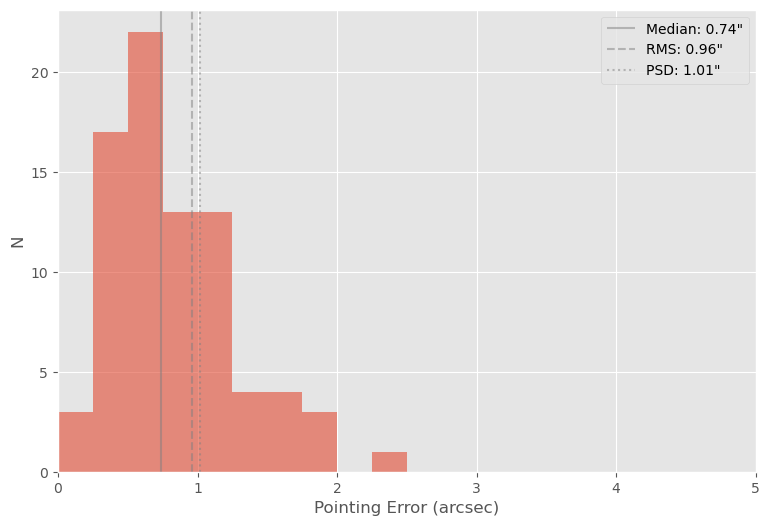

In [10]:
f = pointing_histogram(coo_obs, t_coo)
f.savefig("pointing_hist.png")

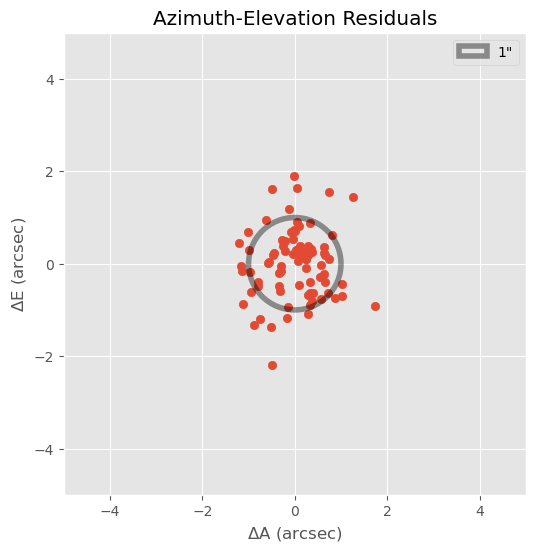

In [11]:
f = pointing_residuals(coo_obs, t_coo)
f.savefig("pointing_resid.png")

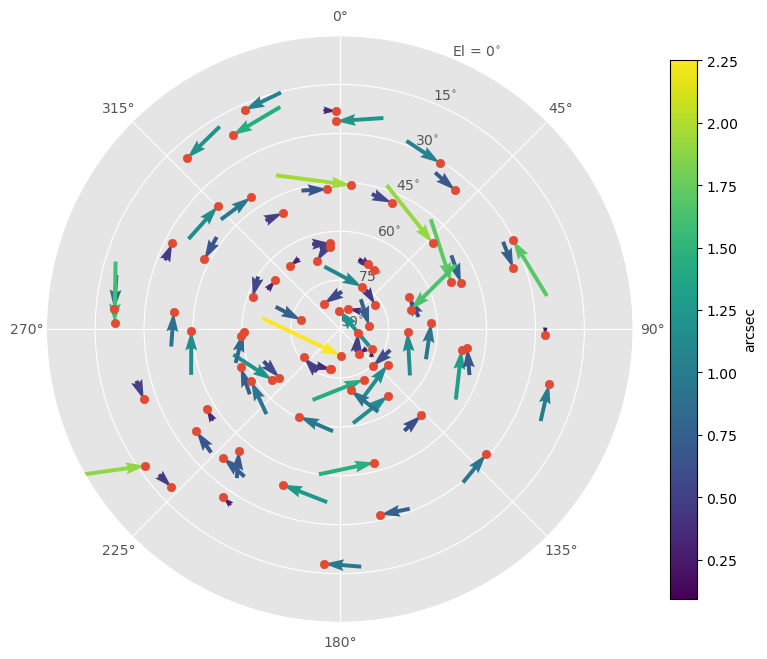

In [12]:
f = pointing_sky(coo_obs, t_coo)
f.savefig("pointing_sky.png")

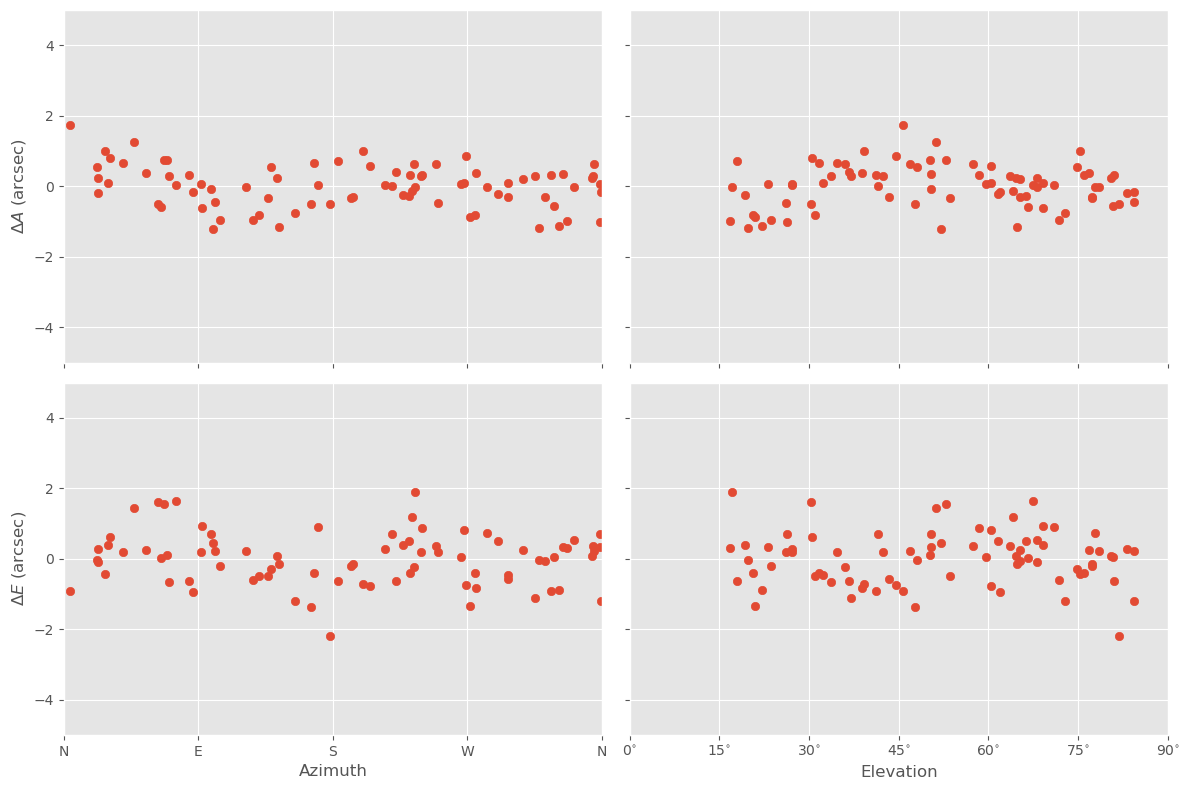

In [13]:
f = pointing_azel_resid(coo_obs, t_coo)
f.savefig("pointing_azel_resid.png")

In [14]:
tpoint_model = pm.Model()
deg2rad = np.pi / 180
with tpoint_model:
    az = pm.Data('az', coo_obs.az)
    el = pm.Data('el', coo_obs.alt)
    az_raw = pm.Data('az_raw', coo_raw.az)
    el_raw = pm.Data('el_raw', coo_raw.alt)
 
    ia = pm.Normal('ia', 1200., 100)
    ie = pm.Normal('ie', 0., 50.)
    an = pm.Normal('an', 0., 20.)
    aw = pm.Normal('aw', 0., 20.)
    ca = pm.Normal('ca', 0., 30.)
    npae = pm.Normal('npae', 0., 30.)
    tf = pm.Normal('tf', 0., 50.)
    tx = pm.Normal('tx', 0., 20.)
    az_sigma = pm.HalfNormal('az_sigma', sigma=1.)
    el_sigma = pm.HalfNormal('el_sigma', sigma=1.)

    daz = -ia 
    daz -= an * pm.math.sin(deg2rad * az) * pm.math.tan(deg2rad * el) 
    daz -= aw * pm.math.cos(deg2rad * az) * pm.math.tan(deg2rad * el) 
    daz -= ca / pm.math.cos(deg2rad * el) 
    daz -= npae * pm.math.tan(deg2rad * el)

    dalt = ie 
    dalt -= an * pm.math.cos(deg2rad * az) 
    dalt += aw * pm.math.sin(deg2rad * az) 
    dalt -= tf * pm.math.cos(deg2rad * el) 
    dalt -= tx / pm.math.tan(deg2rad * el)

    _ = pm.Normal('azerr', mu=0., sigma=az_sigma/3600, observed=pm.math.cos(deg2rad * el) * (az - (az_raw + daz/3600.)))
    _ = pm.Normal('elerr', mu=0., sigma=el_sigma/3600, observed=el - (el_raw + dalt/3600.))

    idata = pm.sample(
        4000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=8675309
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [el_sigma, az_sigma, tx, tf, npae, ca, aw, an, ie, ia]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 70 seconds.


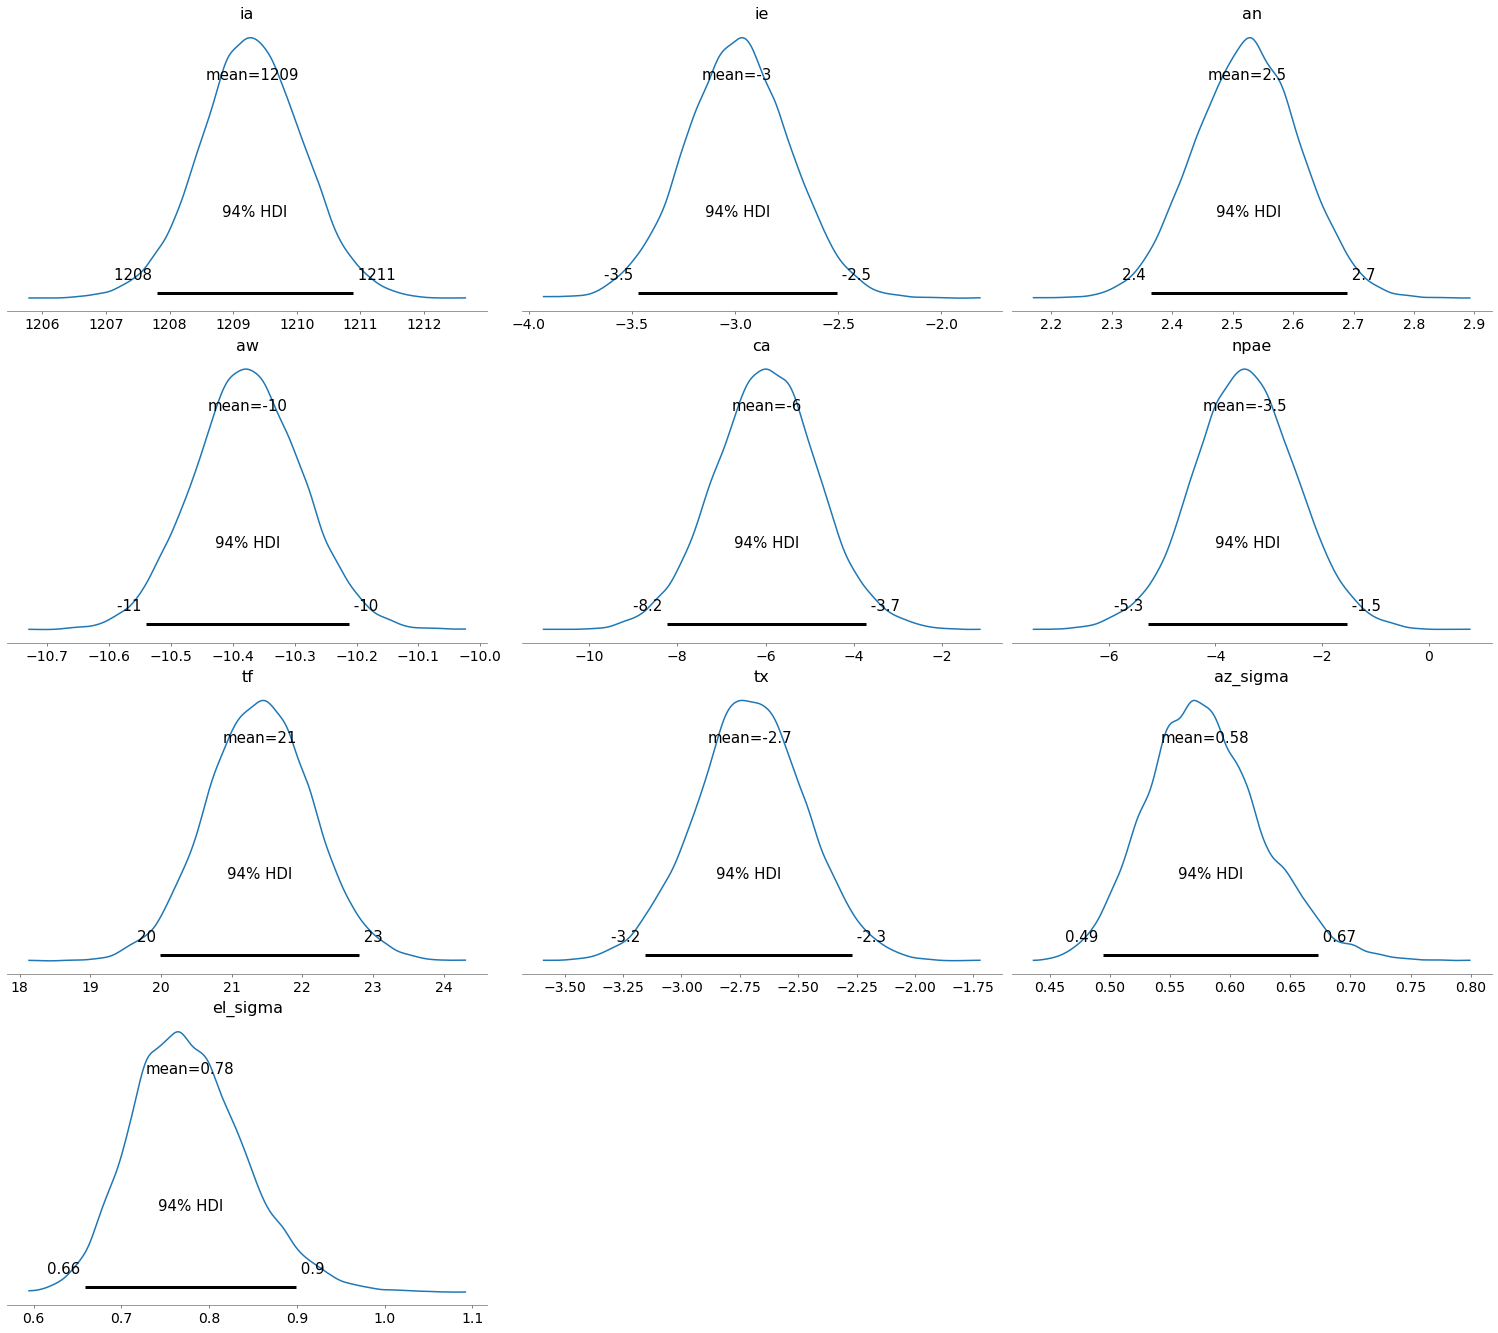

In [15]:
f = arviz.plot_posterior(idata)
plt.savefig("posterior.pdf")

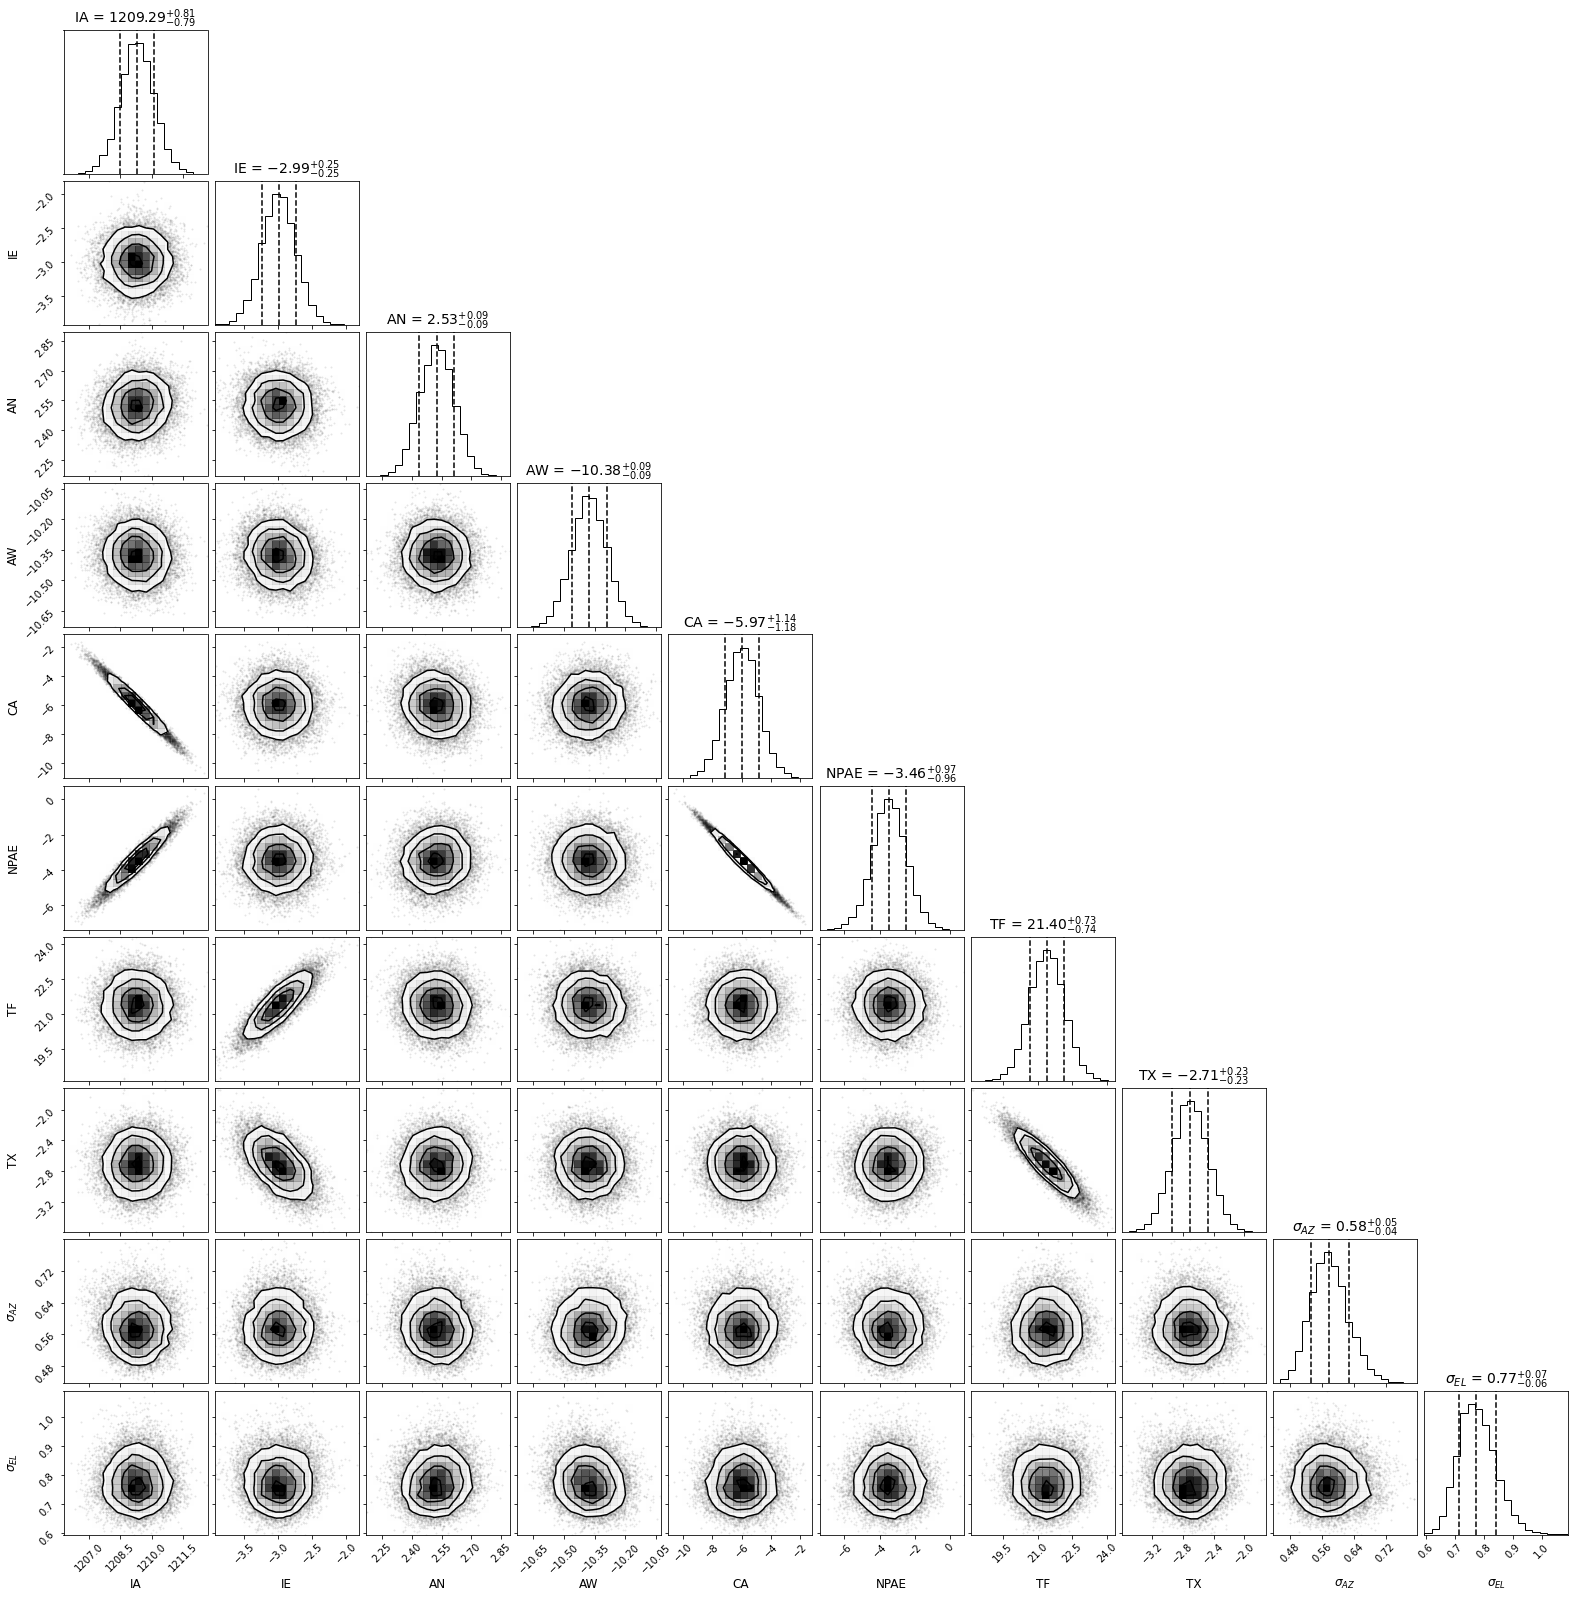

In [16]:
f = corner.corner(
    idata,
    labels=["IA", "IE", "AN", "AW", "CA", "NPAE", "TF", "TX", r"$\sigma_{AZ}$", r"$\sigma_{EL}$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, 
    title_kwargs={"fontsize": 14},
    label_kwargs={"fontsize": 12},
    truths={
        'ia': None, 
        'ie': None,
        'an': None,
        'aw': None,
        'ca': None,
        'npae': None,
        'tf': None,
        'tx': None,
        'el_sigma': None,
        'az_sigma': None
    }
)
f.savefig("corner.pdf")

In [33]:
t_fit = arviz.summary(idata, round_to=8)
t_fit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ia,1209.967921,0.654189,1208.784474,1211.259111,0.008759,0.006194,5586.816420,7797.837009,1.000483
ie,-2.966061,0.256755,-3.452638,-2.484705,0.002817,0.001992,8315.737011,10001.203364,1.000073
an,2.474395,0.069139,2.341602,2.599658,0.000561,0.000397,15178.172800,11235.714667,1.000060
aw,-10.412531,0.059135,-10.527415,-10.304039,0.000472,0.000334,15694.160085,11105.752048,1.000469
ca,-6.967468,1.185232,-9.251366,-4.784107,0.015920,0.011301,5551.174286,7553.921588,1.000506
npae,-2.637647,1.093307,-4.670734,-0.558870,0.014555,0.010293,5649.532615,7632.197043,1.000458
tf,21.457417,0.751724,19.988241,22.807215,0.009090,0.006428,6836.866307,7951.482837,1.000127
tx,-2.712993,0.237618,-3.176136,-2.285266,0.002686,0.001900,7828.955156,9733.986509,0.999999
az_sigma,1.289069,0.105411,1.101025,1.494514,0.000886,0.000633,14475.542620,10948.487875,1.000410
el_sigma,0.776778,0.062738,0.660961,0.893873,0.000502,0.000361,16205.070101,10929.810046,1.000239


In [17]:
t_fit = arviz.summary(idata, round_to=8)
t_fit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ia,1209.295224,0.813190,1207.796999,1210.880262,0.010102,0.007143,6499.097786,7562.348317,1.000482
ie,-2.989976,0.255653,-3.468807,-2.505232,0.002904,0.002054,7748.206833,9700.209995,1.000256
an,2.524385,0.086928,2.364724,2.688452,0.000702,0.000497,15322.136230,12087.172338,0.999932
aw,-10.376320,0.087343,-10.539708,-10.211929,0.000738,0.000522,14004.045987,10832.822236,1.000267
ca,-5.979173,1.182241,-8.223103,-3.720698,0.014729,0.010416,6454.875377,7043.847947,1.000589
npae,-3.453560,0.980671,-5.257570,-1.539748,0.012117,0.008700,6565.867861,7530.495627,1.000523
tf,21.395828,0.749452,19.991768,22.805328,0.009199,0.006505,6638.824906,8474.473910,1.000240
tx,-2.704803,0.236066,-3.158105,-2.268191,0.002653,0.001876,7924.317280,9783.199620,1.000121
az_sigma,0.579317,0.048316,0.494081,0.673206,0.000414,0.000295,13905.198333,11443.823901,1.000188
el_sigma,0.777742,0.064708,0.659170,0.899362,0.000594,0.000423,12007.794787,10752.413971,1.000131


In [23]:
mc_coo = tpoint(
    coo_raw, 
    t_fit.loc['ia', 'mean'],
    t_fit.loc['ie', 'mean'],
    t_fit.loc['an', 'mean'],
    t_fit.loc['aw', 'mean'],
    t_fit.loc['ca', 'mean'],
    t_fit.loc['npae', 'mean'],
    t_fit.loc['tf', 'mean'],
    t_fit.loc['tx', 'mean']
)

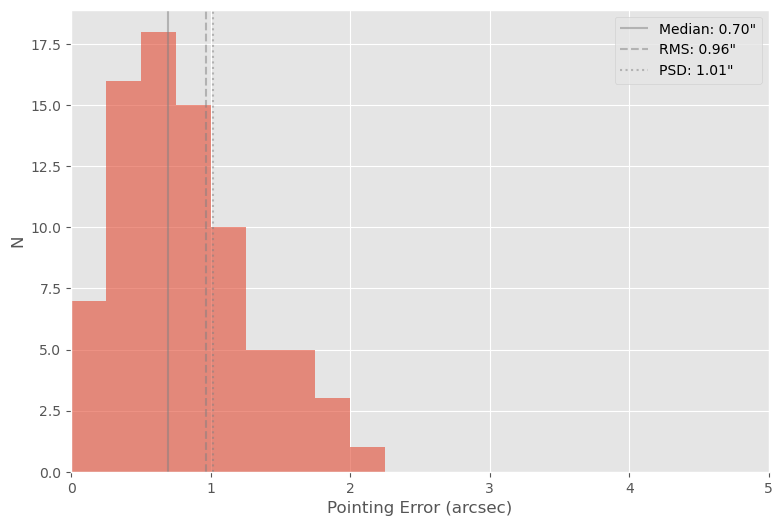

In [24]:
f = pointing_histogram(coo_obs, mc_coo)
f.savefig("pymc_hist.png")

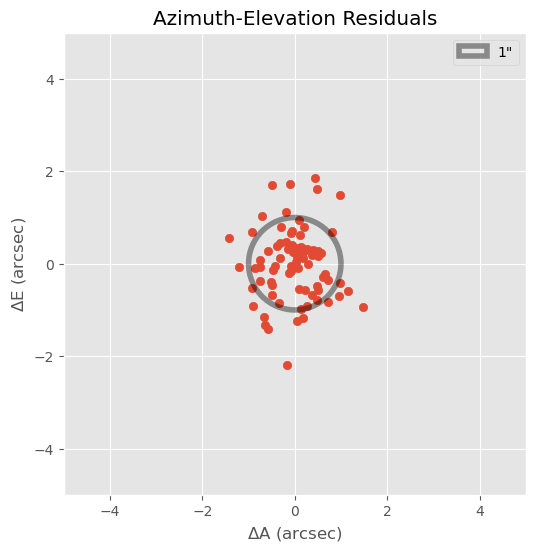

In [25]:
f = pointing_residuals(coo_obs, mc_coo)
f.savefig("pymc_resid.png")

In [62]:
import pickle
with open("k_and_e.pkl", 'wb') as fp:
    pickle.dump(idata, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
import sys
sys.getrecursionlimit()

10000

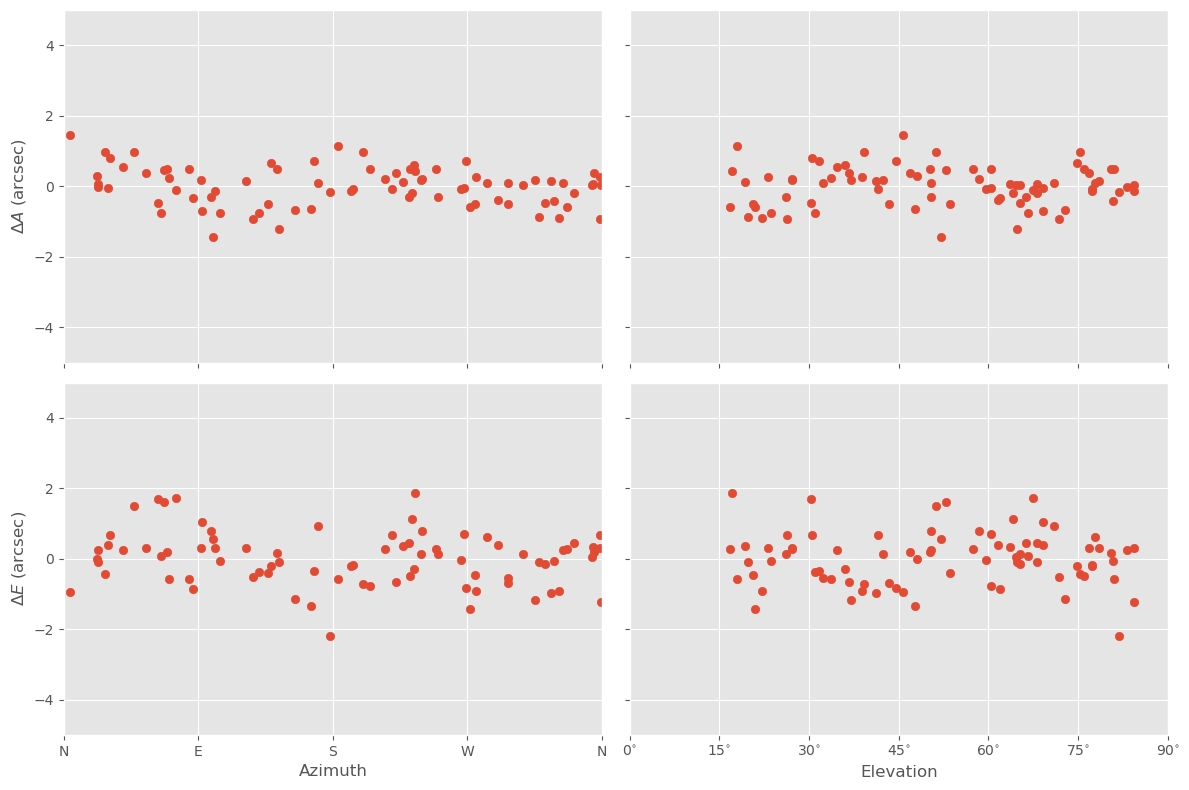

In [26]:
f = pointing_azel_resid(coo_obs, mc_coo)
f.savefig("pymc_azel_resid.png")